In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import sys
import re
import shapefile
from math import radians, cos, sin, asin, sqrt
from xml.etree import ElementTree as ET
from mpl_toolkits.basemap import Basemap

In [29]:
rS1 = pd.read_json("26853582/real_state.json")
xmlRs = ET.parse("26853582/real_state.xml")
hos = pd.read_html("26853582/hospitals.html")[0]
sC = pd.read_excel("26853582/shopingcenters.xlsx")
sM = pd.read_json("26853582/supermarkets.json")

# The transport info
stopsFile = pd.read_csv("1. GTFS - Melbourne Train Information - From PTV (9 Oct 2015)/GTFS - Melbourne Train Information/stops.txt")
stop_time = pd.read_csv("1. GTFS - Melbourne Train Information - From PTV (9 Oct 2015)/GTFS - Melbourne Train Information/stop_times.txt")
trips = pd.read_csv("1. GTFS - Melbourne Train Information - From PTV (9 Oct 2015)/GTFS - Melbourne Train Information/trips.txt")
shapes = pd.read_csv("1. GTFS - Melbourne Train Information - From PTV (9 Oct 2015)/GTFS - Melbourne Train Information/shapes.txt")
calendar = pd.read_csv("1. GTFS - Melbourne Train Information - From PTV (9 Oct 2015)/GTFS - Melbourne Train Information/calendar.txt")
route = pd.read_csv("1. GTFS - Melbourne Train Information - From PTV (9 Oct 2015)/GTFS - Melbourne Train Information/routes.txt")

In [3]:
root = xmlRs.getroot()
for i in root.getchildren():
    print(i)

<Element 'bathrooms' at 0x000001C88F179CC8>
<Element 'price' at 0x000001C88F0E0F48>
<Element 'bedrooms' at 0x000001C88F1EF138>
<Element 'parking_space' at 0x000001C88F25B2C8>
<Element 'year' at 0x000001C88F2C7458>
<Element 'lat' at 0x000001C88F3335E8>
<Element 'lng' at 0x000001C88F3AF778>
<Element 'property_type' at 0x000001C88F42D908>
<Element 'addr_street' at 0x000001C88F4A7A98>
<Element 'property_id' at 0x000001C88F523F48>


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  


In [4]:
def getXmlToPd(xmlRs):
    rSList = []
    root = xmlRs.getroot()
    for attri in root.getchildren():
        temp = []
        for ele in attri:
            temp.append(ele.text)
        rSList.append(temp)
    res = pd.DataFrame(rSList).T
    res.columns = ["bathrooms","price","bedrooms","parking_space","year","lat","lng","property_type","addr_street","property_id"]
    return res

In [5]:
rS2 = getXmlToPd(xmlRs)

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  after removing the cwd from sys.path.


In [6]:
rS1.head()

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year
0,18 Liverpool Circuit,2.0,4.0,-37.581627,144.938812,2.0,5040000.0,25699.0,house,2008.0
1,64 Vernon Street,2.0,4.0,-37.832326,144.871203,2.0,6750000.0,4605.0,house,2009.0
2,1&4/93 Esdale Street,2.0,3.0,-37.813541,145.172271,2.0,10175000.0,58429.0,house,2016.0
3,14 Central Park Avenue,3.0,4.0,-37.773393,144.876768,2.0,5292000.0,11123.0,house,2010.0
4,12 Hamilton Street,1.0,2.0,-37.807190,144.887249,0.0,13040000.0,261.0,house,2013.0


In [7]:
rS1.dtypes

addr_street       object
bathrooms        float64
bedrooms         float64
lat              float64
lng              float64
parking_space    float64
price            float64
property_id      float64
property_type     object
year             float64
dtype: object

In [8]:
rS1.loc[list(set(rS1[rS1.isnull().values == True].index))]

,addr_street,bathrooms,bedrooms,lat,lng,parking_space,price,property_id,property_type,year
994,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
551,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
1000,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
587,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
887,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN


In [9]:
rS1 = rS1.dropna()

In [10]:
rS2.head()

,bathrooms,price,bedrooms,parking_space,year,lat,lng,property_type,addr_street,property_id
0,1.0,9088000.0,3.0,3.0,2013.0,-37.659898,144.927728,house,75 Almurta Avenue,19490.0
1,1.0,18400000.0,2.0,1.0,2015.0,-37.747833,144.924634,house,88 Napier Crescent,14852.0
2,1.0,7065000.0,2.0,1.0,2013.0,-37.815582,144.995301,house,143 Lennox Street,52355.0
3,1.0,6580000.0,4.0,2.0,2013.0,-37.928347,145.107253,house,1/11 Arunta Crescent,77043.0
4,2.0,9300000.0,4.0,2.0,2012.0,-37.972659,145.065708,house,18 Cobham Street,90126.0


In [11]:
rS2.dtypes

bathrooms        object
price            object
bedrooms         object
parking_space    object
year             object
lat              object
lng              object
property_type    object
addr_street      object
property_id      object
dtype: object

In [12]:
rS2[rS2["lat"] == "nan"]

,bathrooms,price,bedrooms,parking_space,year,lat,lng,property_type,addr_street,property_id
358,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
577,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
643,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [13]:
rS2[rS2["property_id"] == "nan"]

,bathrooms,price,bedrooms,parking_space,year,lat,lng,property_type,addr_street,property_id
358,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
577,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
643,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [14]:
rS2 = rS2.drop([358,577,643])

In [15]:
rS1 = rS1[[ 'property_id', 'lat', 'lng', 'addr_street','price', 'property_type', 'year', 'bedrooms', 'bathrooms','parking_space']]
rS2 = rS2[[ 'property_id', 'lat', 'lng', 'addr_street','price', 'property_type', 'year', 'bedrooms', 'bathrooms','parking_space']]

In [16]:
rS2.head()

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
0,19490.0,-37.659898,144.927728,75 Almurta Avenue,9088000.0,house,2013.0,3.0,1.0,3.0
1,14852.0,-37.747833,144.924634,88 Napier Crescent,18400000.0,house,2015.0,2.0,1.0,1.0
2,52355.0,-37.815582,144.995301,143 Lennox Street,7065000.0,house,2013.0,2.0,1.0,1.0
3,77043.0,-37.928347,145.107253,1/11 Arunta Crescent,6580000.0,house,2013.0,4.0,1.0,2.0
4,90126.0,-37.972659,145.065708,18 Cobham Street,9300000.0,house,2012.0,4.0,2.0,2.0


In [17]:
rS1.head()

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
0,25699.0,-37.581627,144.938812,18 Liverpool Circuit,5040000.0,house,2008.0,4.0,2.0,2.0
1,4605.0,-37.832326,144.871203,64 Vernon Street,6750000.0,house,2009.0,4.0,2.0,2.0
2,58429.0,-37.813541,145.172271,1&4/93 Esdale Street,10175000.0,house,2016.0,3.0,2.0,2.0
3,11123.0,-37.773393,144.876768,14 Central Park Avenue,5292000.0,house,2010.0,4.0,3.0,2.0
4,261.0,-37.807190,144.887249,12 Hamilton Street,13040000.0,house,2013.0,2.0,1.0,0.0


In [18]:
data = pd.concat([rS2,rS1],ignore_index=True)
data.head()

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
0,19490.0,-37.659898,144.927728,75 Almurta Avenue,9088000.0,house,2013.0,3.0,1.0,3.0
1,14852.0,-37.747833,144.924634,88 Napier Crescent,18400000.0,house,2015.0,2.0,1.0,1.0
2,52355.0,-37.815582,144.995301,143 Lennox Street,7065000.0,house,2013.0,2.0,1.0,1.0
3,77043.0,-37.928347,145.107253,1/11 Arunta Crescent,6580000.0,house,2013.0,4.0,1.0,2.0
4,90126.0,-37.972659,145.065708,18 Cobham Street,9300000.0,house,2012.0,4.0,2.0,2.0


In [19]:
data.dtypes

property_id      object
lat              object
lng              object
addr_street      object
price            object
property_type    object
year             object
bedrooms         object
bathrooms        object
parking_space    object
dtype: object

In [20]:
data[["lat","lng"]] = data[["lat","lng"]].apply(pd.to_numeric)
data[["property_id","price","year","bedrooms","bathrooms","parking_space"]] = data[["property_id","price","year","bedrooms","bathrooms","parking_space"]].apply(pd.to_numeric)
data[["property_id","price","year","bedrooms","bathrooms","parking_space"]] = data[["property_id","price","year","bedrooms","bathrooms","parking_space"]].astype(int)

In [21]:
data.head()

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
0,19490,-37.659898,144.927728,75 Almurta Avenue,9088000,house,2013,3,1,3
1,14852,-37.747833,144.924634,88 Napier Crescent,18400000,house,2015,2,1,1
2,52355,-37.815582,144.995301,143 Lennox Street,7065000,house,2013,2,1,1
3,77043,-37.928347,145.107253,1/11 Arunta Crescent,6580000,house,2013,4,1,2
4,90126,-37.972659,145.065708,18 Cobham Street,9300000,house,2012,4,2,2


In [22]:
def haversine(lon1, lat1, lon2, lat2): 
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    # haversine
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6378 
    return c * r * 1000

def addScInfo(data,sC):
    for dataIndex in data.index:
        lng1 = data.loc[dataIndex].lng
        lat1 = data.loc[dataIndex].lat
        distance = 10000000000
        scId = ""
        for scIndex in sC.index:
            lng2 = sC.loc[scIndex].lng
            lat2 = sC.loc[scIndex].lat
            tempDistance = haversine(lng1,lat1,lng2,lat2)
            if distance > tempDistance:
                distance = tempDistance
                scId = sC.loc[scIndex].sc_id
        data.loc[dataIndex,"distance_to_sc"] = distance
        data.loc[dataIndex,"shopping_center_id"] = scId
    return data

def addHosInfo(data,hos):
    for dataIndex in data.index:
        lng1 = data.loc[dataIndex].lng
        lat1 = data.loc[dataIndex].lat
        distance = 10000000000
        hosId = ""
        for hosIndex in hos.index:
            lng2 = hos.loc[hosIndex].lng
            lat2 = hos.loc[hosIndex].lat
            tempDistance = haversine(lng1,lat1,lng2,lat2)
            if distance > tempDistance:
                distance = tempDistance
                hosId = hos.loc[hosIndex].id
        data.loc[dataIndex,"distance_to_hospital"] = distance        
        data.loc[dataIndex,"hospital_id"] = hosId
    return data

def addSMInfo(data,sM):
    for dataIndex in data.index:
        lng1 = data.loc[dataIndex].lng
        lat1 = data.loc[dataIndex].lat
        distance = 10000000000
        sMId = ""
        for sMIndex in sM.index:
            lng2 = sM.loc[sMIndex].lng
            lat2 = sM.loc[sMIndex].lat
            tempDistance = haversine(lng1,lat1,lng2,lat2)
            if distance > tempDistance:
                distance = tempDistance
                sMId = sM.loc[sMIndex].id
        data.loc[dataIndex, "distance_to_supermaket"] = distance
        data.loc[dataIndex, "supermarket_id"] = sMId
    return data

def addStation(data,sT):
    for dataIndex in data.index:
        lng1 = data.loc[dataIndex].lng
        lat1 = data.loc[dataIndex].lat
        distance = 10000000000
        sTId = ""
        for sTIndex in sT.index:
            lng2 = sT.loc[sTIndex].stop_lon
            lat2 = sT.loc[sTIndex].stop_lat
            tempDistance = haversine(lng1,lat1,lng2,lat2)
            if distance > tempDistance:
                distance = tempDistance
                sTId = sT.loc[sTIndex].stop_id
        data.loc[dataIndex, "distance_to_train_station"] = distance
        data.loc[dataIndex, "train_station_id"] = sTId
    return data


In [23]:
start = time.time()
data = addScInfo(data, sC)
stop = time.time()
print("Add SC information func cost",int(stop-start)," second")

Add SC information func cost 98  second


In [24]:
start = time.time()
data = addHosInfo(data,hos)
stop = time.time()
print("Add hospital infomation cost",int(stop-start)," second")

Add hospital infomation cost 170  second


In [25]:
start = time.time()
data = addSMInfo(data,sM)
stop = time.time()
print("Add supermarket infomation cost",int(stop-start)," second")

Add supermarket infomation cost 193  second


In [26]:
start = time.time()
addStation(data,stopsFile)
stop = time.time()
print("Add train station infomation cost",int(stop-start)," second")

Add train station infomation cost 189  second


In [30]:
# get the service id in weekday
weekdaySID = list(calendar[(calendar["saturday"] == 0) & calendar["sunday"] == 0].service_id)
print(weekdaySID)

['T2', 'T6', 'T5', 'T2_1', 'T6_1', 'T5_1', 'T0', 'T2_2', 'T0+a6', 'T0+a5', 'T5+tg', 'T5+ph', 'T5+tg_1', 'T5+ph_1', 'T5+ao', 'T5+ta']


In [31]:
# have look on route info
route.head()

,route_id,agency_id,route_short_name,route_long_name,route_type
0,2-ALM-B-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
1,2-ALM-C-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
2,2-ALM-D-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
3,2-ALM-E-mjp-1,1,Alamein,Alamein - City (Flinders Street),2
4,2-ALM-F-mjp-1,1,Alamein,Alamein - City (Flinders Street),2


In [32]:
# get the route id which is go to city
routeToCity = list(route[route["route_long_name"].str.contains("- City")].route_id)
print(routeToCity)

['2-ALM-B-mjp-1', '2-ALM-C-mjp-1', '2-ALM-D-mjp-1', '2-ALM-E-mjp-1', '2-ALM-F-mjp-1', '2-BDM-B-mjp-1', '2-BDM-C-mjp-1', '2-BDM-D-mjp-1', '2-BDM-E-mjp-1', '2-BDM-F-mjp-1', '2-CRB-B-mjp-1', '2-CRB-C-mjp-1', '2-CRB-D-mjp-1', '2-CRB-E-mjp-1', '2-CRB-F-mjp-1', '2-FKN-B-mjp-1', '2-FKN-C-mjp-1', '2-FKN-D-mjp-1', '2-FKN-E-mjp-1', '2-FKN-F-mjp-1', '2-GLW-B-mjp-1', '2-GLW-C-mjp-1', '2-GLW-D-mjp-1', '2-GLW-E-mjp-1', '2-GLW-F-mjp-1', '2-HBG-B-mjp-1', '2-HBG-C-mjp-1', '2-HBG-D-mjp-1', '2-HBG-E-mjp-1', '2-HBG-F-mjp-1', '2-PKM-B-mjp-1', '2-PKM-C-mjp-1', '2-PKM-D-mjp-1', '2-PKM-E-mjp-1', '2-PKM-F-mjp-1', '2-SDM-B-mjp-1', '2-SDM-C-mjp-1', '2-SDM-D-mjp-1', '2-SDM-E-mjp-1', '2-SDM-F-mjp-1', '2-SYM-B-mjp-1', '2-SYM-C-mjp-1', '2-SYM-D-mjp-1', '2-SYM-E-mjp-1', '2-SYM-F-mjp-1', '2-WBE-B-mjp-1', '2-WBE-C-mjp-1', '2-WBE-D-mjp-1', '2-WBE-E-mjp-1', '2-WBE-F-mjp-1', '2-WMN-B-mjp-1', '2-WMN-C-mjp-1', '2-WMN-D-mjp-1', '2-WMN-E-mjp-1', '2-WMN-F-mjp-1']


In [33]:
# now get the trip info which in weekday, to city and headsign city
tripToCity = trips[(trips["route_id"].isin(routeToCity)) & (trips["service_id"].isin(weekdaySID))&(trips["trip_headsign"]=="City (Flinders Street)")]
tripToCity.head()

,route_id,service_id,trip_id,shape_id,trip_headsign,direction_id
0,2-ALM-F-mjp-1,T0,17067982.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
1,2-ALM-F-mjp-1,T0,17067988.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
2,2-ALM-F-mjp-1,T0,17067992.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
3,2-ALM-F-mjp-1,T0,17067999.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0
4,2-ALM-F-mjp-1,T0,17068003.T0.2-ALM-F-mjp-1.1.H,2-ALM-F-mjp-1.1.H,City (Flinders Street),0


In [34]:
# Get these trips' id
tid = list(tripToCity.trip_id)

In [35]:
# Get transport info of these trips
trans = stop_time[stop_time["trip_id"].isin(tid)]
trans.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,17182517.T2.2-ALM-B-mjp-1.1.H,04:57:00,04:57:00,19847,1,NaN,0,0,0.000000
1,17182517.T2.2-ALM-B-mjp-1.1.H,04:58:00,04:58:00,19848,2,NaN,0,0,723.017818
2,17182517.T2.2-ALM-B-mjp-1.1.H,05:00:00,05:00:00,19849,3,NaN,0,0,1951.735072
3,17182517.T2.2-ALM-B-mjp-1.1.H,05:02:00,05:02:00,19850,4,NaN,0,0,2899.073349
4,17182517.T2.2-ALM-B-mjp-1.1.H,05:04:00,05:04:00,19851,5,NaN,0,0,3927.090952


In [36]:
stopsFile[stopsFile["stop_id"] == 19854]

,stop_id,stop_name,stop_short_name,stop_lat,stop_lon
29,19854,Flinders Street Railway Station,Melbourne City,-37.818305,144.966964


In [37]:
# the departure info which not in city and between 7-9 AM
dep = trans[(trans["departure_time"].str.match(r"^0[7-8]"))&(trans["stop_id"] != 19854)]
dep = dep[["trip_id","departure_time","stop_id"]]
dep.head()

,trip_id,departure_time,stop_id
33,17182535.T2.2-ALM-B-mjp-1.1.H,07:00:00,19852
34,17182535.T2.2-ALM-B-mjp-1.1.H,07:03:00,19853
35,17182541.T2.2-ALM-B-mjp-1.1.H,07:08:00,19847
36,17182541.T2.2-ALM-B-mjp-1.1.H,07:09:00,19848
37,17182541.T2.2-ALM-B-mjp-1.1.H,07:11:00,19849


In [38]:
# The info of these trip arrive to City
depTid = list(set(dep.trip_id))
arrive = trans[(trans["trip_id"].isin(depTid))&(trans["stop_id"] == 19854)]
arrive = arrive[["trip_id","arrival_time"]]
arrive.head()

,trip_id,arrival_time
1004,17183032.T6.2-ALM-B-mjp-1.2.H,07:20:00
1021,17183036.T6.2-ALM-B-mjp-1.2.H,07:37:00
1038,17183054.T6.2-ALM-B-mjp-1.2.H,09:12:00
1055,17183040.T6.2-ALM-B-mjp-1.2.H,07:53:00
1072,17183044.T6.2-ALM-B-mjp-1.2.H,08:13:00


In [39]:
# merge two table find the directly to city trip
transInfo = pd.merge(dep,arrive,how="inner",on=["trip_id"])
transInfo.head()

,trip_id,departure_time,stop_id,arrival_time
0,17183032.T6.2-ALM-B-mjp-1.2.H,07:00:00,19904,07:20:00
1,17183032.T6.2-ALM-B-mjp-1.2.H,07:02:00,19905,07:20:00
2,17183032.T6.2-ALM-B-mjp-1.2.H,07:04:00,19906,07:20:00
3,17183032.T6.2-ALM-B-mjp-1.2.H,07:07:00,19908,07:20:00
4,17183032.T6.2-ALM-B-mjp-1.2.H,07:10:00,19843,07:20:00


In [40]:
def calMin(transInfo):
    for i in transInfo.index:
        arrTime = transInfo.loc[i].arrival_time
        depTime = transInfo.loc[i].departure_time
        arr = int(arrTime[0:2])*60 + int(arrTime[3:5])
        dep = int(depTime[0:2])*60 + int(depTime[3:5])
        transInfo.loc[i, "travel_time_to_CBD"] = arr - dep
    return transInfo

In [41]:
newTransInfo = calMin(transInfo)
newTransInfo.head()

,trip_id,departure_time,stop_id,arrival_time,travel_time_to_CBD
0,17183032.T6.2-ALM-B-mjp-1.2.H,07:00:00,19904,07:20:00,20.0
1,17183032.T6.2-ALM-B-mjp-1.2.H,07:02:00,19905,07:20:00,18.0
2,17183032.T6.2-ALM-B-mjp-1.2.H,07:04:00,19906,07:20:00,16.0
3,17183032.T6.2-ALM-B-mjp-1.2.H,07:07:00,19908,07:20:00,13.0
4,17183032.T6.2-ALM-B-mjp-1.2.H,07:10:00,19843,07:20:00,10.0


In [42]:
newTransInfo = transInfo[["stop_id","travel_time_to_CBD"]]
newTransInfo.head()

,stop_id,travel_time_to_CBD
0,19904,20.0
1,19905,18.0
2,19906,16.0
3,19908,13.0
4,19843,10.0


In [43]:
timeToCBD = newTransInfo.groupby(["stop_id"]).mean()

In [96]:
timeToCBD

,travel_time_to_CBD
stop_id,
15351,49.500000
15353,45.500000
19835,19.117647
19837,21.147727
19838,23.147727
19839,25.943182
19840,28.139785
19841,4.561798
19842,3.942177


In [44]:
def addMinToCBD(data,timeToCBD):
    for i in data.index:
        station = data.loc[i].train_station_id
        if station in timeToCBD.index:
            data.loc[i,"travel_min_to_CBD"] = timeToCBD.loc[station].travel_time_to_CBD
            data.loc[i,"transfer_flag"] = 0
        elif station == 19854:
            data.loc[i,"travel_min_to_CBD"] = 0
            data.loc[i,"transfer_flag"] = 0
        else:
            data.loc[i,"travel_min_to_CBD"] = 0
            data.loc[i,"transfer_flag"] = 1
    return data

In [97]:
data = addMinToCBD(data,timeToCBD)
data.head()

,property_id,lat,lng,addr_street,suburb,price,property_type,year,bedrooms,bathrooms,...,shopping_center_id,distance_to_sc,train_station_id,distance_to_train_station,travel_min_to_CBD,transfer_flag,hospital_id,distance_to_hospital,supermarket_id,distance_to_supermaket
0,19490,-37.659898,144.927728,75 Almurta Avenue,COOLAROO,9088000,house,2013,3,1,...,SC_072,1127.645920,44817.0,191.933932,39.329545,0.0,hospital_104,1210.036605,S_153,2094.700431
1,14852,-37.747833,144.924634,88 Napier Crescent,ESSENDON,18400000,house,2015,2,1,...,SC_082,2278.521618,20036.0,332.577252,23.530612,0.0,hospital_184,1828.583450,S_197,1300.797883
2,52355,-37.815582,144.995301,143 Lennox Street,RICHMOND,7065000,house,2013,2,1,...,SC_068,2049.379302,19978.0,348.252627,6.060606,0.0,hospital_172,142.688537,S_076,666.148962
3,77043,-37.928347,145.107253,1/11 Arunta Crescent,OAKLEIGH SOUTH,6580000,house,2013,4,1,...,SC_087,4983.549170,19915.0,1235.478091,38.803922,0.0,hospital_076,1379.857992,S_170,957.324960
4,90126,-37.972659,145.065708,18 Cobham Street,CHELTENHAM,9300000,house,2012,4,2,...,SC_003,2056.723564,19865.0,1025.933286,39.660714,0.0,hospital_133,969.710658,S_011,1032.027431


In [46]:
maxLat = max(data.lat)
minLat = min(data.lat)
maxLng = max(data.lng)
minLng = min(data.lng)
print("Max Lat:",maxLat)
print("Min Lat:",minLat)
print("Max lng:",maxLng)
print("Min lng:",minLng)

Max Lat: -37.570585
Min Lat: -38.078140999999995
Max lng: 145.3689117
Min lng: 144.630495


In [47]:
vic = shapefile.Reader("vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp")

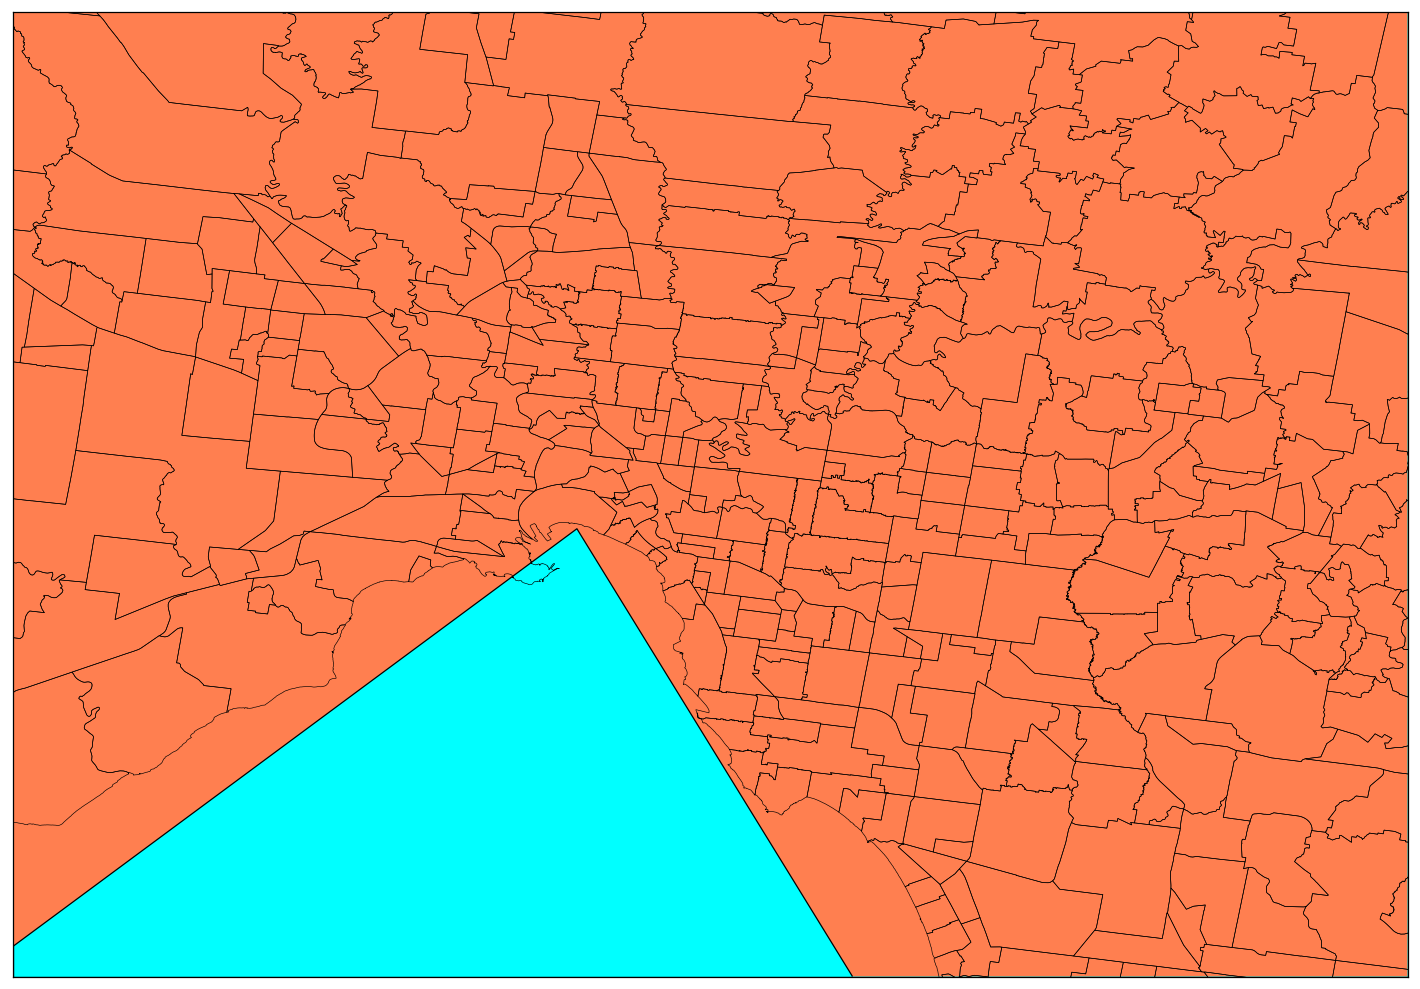

In [51]:
plt.figure(figsize=(20,15),dpi=90)
m = Basemap(llcrnrlat=minLat-0.005,llcrnrlon=minLng-0.005,urcrnrlat=maxLat+0.005,urcrnrlon=maxLng+0.005)
m.readshapefile("vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp","vic")
m.drawmapboundary(fill_color='aqua')
m.fillcontinents(color='coral',lake_color='aqua')
m.drawcoastlines()
plt.show()

In [52]:
vicShape = vic.shapeRecords()

In [86]:
def addAreaInfo(data):
    for dataIndex in data.index:
        lng = data.loc[dataIndex].lng
        lat = data.loc[dataIndex].lat
        point = (lng, lat)
        data.loc[dataIndex,"suburb"] = pointInd(point)   
    return data


In [87]:
def pointInd(point):
    pointLng = point[0]
    pointLat = point[1]
    temp = []
    for area in vicShape:
        minLng = area.shape.bbox[0]
        minLat = area.shape.bbox[1]
        maxLng = area.shape.bbox[2]
        maxLat = area.shape.bbox[3]
        meanLng = (maxLng + minLng)/2
        meanLat = (maxLat + minLat)/2
        if (pointLng<=maxLng and pointLng >= minLng) and (pointLat<=maxLat and pointLat>=minLat):
            distanceToAreaCentre = sqrt(((pointLng-meanLng)**2)+((pointLat-meanLat)**2))
            temp.append([area.record[6],distanceToAreaCentre])
    if len(temp) == 1:
        return temp[0][0]
    else:
        tempDistance = 100
        for i in temp:
            distance = i[1]
            if tempDistance > distance:
                tempDistance = distance
                tempAreaName = i[0]
        return tempAreaName

In [90]:
 data = addAreaInfo(data)

In [91]:
data.head()

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,...,shopping_center_id,distance_to_hospital,hospital_id,distance_to_supermaket,supermarket_id,distance_to_train_station,train_station_id,travel_min_to_CBD,transfer_flag,suburb
0,19490,-37.659898,144.927728,75 Almurta Avenue,9088000,house,2013,3,1,3,...,SC_072,1210.036605,hospital_104,2094.700431,S_153,191.933932,44817.0,39.329545,0.0,COOLAROO
1,14852,-37.747833,144.924634,88 Napier Crescent,18400000,house,2015,2,1,1,...,SC_082,1828.583450,hospital_184,1300.797883,S_197,332.577252,20036.0,23.530612,0.0,ESSENDON
2,52355,-37.815582,144.995301,143 Lennox Street,7065000,house,2013,2,1,1,...,SC_068,142.688537,hospital_172,666.148962,S_076,348.252627,19978.0,6.060606,0.0,RICHMOND
3,77043,-37.928347,145.107253,1/11 Arunta Crescent,6580000,house,2013,4,1,2,...,SC_087,1379.857992,hospital_076,957.324960,S_170,1235.478091,19915.0,38.803922,0.0,OAKLEIGH SOUTH
4,90126,-37.972659,145.065708,18 Cobham Street,9300000,house,2012,4,2,2,...,SC_003,969.710658,hospital_133,1032.027431,S_011,1025.933286,19865.0,39.660714,0.0,CHELTENHAM


In [73]:
data.columns = [[]]

'NURRAN'

In [99]:
data = data[["property_id","lat","lng","addr_street","suburb","price","property_type","year","bedrooms","bathrooms","parking_space","shopping_center_id","distance_to_sc","train_station_id","distance_to_train_station","travel_min_to_CBD","transfer_flag","hospital_id","distance_to_hospital","supermarket_id","distance_to_supermaket"]]
data = data.sort_values(by='property_id')
data.head()

,property_id,lat,lng,addr_street,suburb,price,property_type,year,bedrooms,bathrooms,...,shopping_center_id,distance_to_sc,train_station_id,distance_to_train_station,travel_min_to_CBD,transfer_flag,hospital_id,distance_to_hospital,supermarket_id,distance_to_supermaket
1656,40,-37.820871,144.956233,555 FLINDERS STREET,SOUTHBANK,5012000,house,2011,1,1,...,SC_076,817.810206,22180.0,535.226819,0.676036,0.0,hospital_022,940.780833,S_118,558.852559
951,43,-37.804474,144.958206,604/591 Elizabeth Street,NORTH MELBOURNE,2800000,house,2009,1,1,...,SC_007,1002.637432,19842.0,720.390022,3.942177,0.0,hospital_187,423.632953,S_044,746.119228
948,44,-37.810695,144.957460,607/28 Wills Street,MELBOURNE,4590000,house,2013,2,2,...,SC_007,527.371858,19841.0,213.858881,4.561798,0.0,hospital_022,905.304398,S_044,409.322055
532,123,-37.804475,144.888447,1/148 Pilgrim Street,SEDDON,10230000,house,2016,3,1,...,SC_043,2657.825526,20024.0,344.814031,16.911765,0.0,hospital_056,1278.099233,S_201,937.914425
1523,152,-37.803231,144.887950,10 Margaret Street,SEDDON,10976000,house,2013,4,2,...,SC_043,2558.231817,20023.0,279.967101,18.911765,0.0,hospital_056,1134.728659,S_201,927.030260


In [98]:
data = data.sort_values(by='property_id')

,property_id,lat,lng,addr_street,suburb,price,property_type,year,bedrooms,bathrooms,...,shopping_center_id,distance_to_sc,train_station_id,distance_to_train_station,travel_min_to_CBD,transfer_flag,hospital_id,distance_to_hospital,supermarket_id,distance_to_supermaket
1656,40,-37.820871,144.956233,555 FLINDERS STREET,SOUTHBANK,5012000,house,2011,1,1,...,SC_076,817.810206,22180.0,535.226819,0.676036,0.0,hospital_022,940.780833,S_118,558.852559
951,43,-37.804474,144.958206,604/591 Elizabeth Street,NORTH MELBOURNE,2800000,house,2009,1,1,...,SC_007,1002.637432,19842.0,720.390022,3.942177,0.0,hospital_187,423.632953,S_044,746.119228
948,44,-37.810695,144.957460,607/28 Wills Street,MELBOURNE,4590000,house,2013,2,2,...,SC_007,527.371858,19841.0,213.858881,4.561798,0.0,hospital_022,905.304398,S_044,409.322055
532,123,-37.804475,144.888447,1/148 Pilgrim Street,SEDDON,10230000,house,2016,3,1,...,SC_043,2657.825526,20024.0,344.814031,16.911765,0.0,hospital_056,1278.099233,S_201,937.914425
1523,152,-37.803231,144.887950,10 Margaret Street,SEDDON,10976000,house,2013,4,2,...,SC_043,2558.231817,20023.0,279.967101,18.911765,0.0,hospital_056,1134.728659,S_201,927.030260
1421,162,-37.800597,144.891758,10 Windsor Street,FOOTSCRAY,10880000,house,2015,3,1,...,SC_043,2770.558692,20024.0,213.842945,16.911765,0.0,hospital_003,959.690534,S_201,550.160386
1133,194,-37.803655,144.893378,109 Buckley Street,SEDDON,5670000,house,2014,3,1,...,SC_043,3015.967531,20024.0,210.943859,16.911765,0.0,hospital_003,1325.601507,S_201,520.355365
1025,200,-37.793108,144.893130,11 Commercial Road,FOOTSCRAY,7520000,house,2016,3,1,...,SC_085,2214.322278,20024.0,1056.129508,16.911765,0.0,hospital_003,365.357236,S_201,952.551539
201,238,-37.806203,144.889320,114 Charles Street,SEDDON,9425000,house,2009,3,2,...,SC_043,2816.724782,20024.0,453.113240,16.911765,0.0,hospital_056,1480.744700,S_201,976.242681
1005,261,-37.807190,144.887249,12 Hamilton Street,SEDDON,13040000,house,2013,2,1,...,SC_043,2719.341341,20023.0,622.478042,18.911765,0.0,hospital_056,1567.634257,S_201,1187.514393
